In [2]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import colorcet as cc
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, LogColorMapper

In [3]:
cnx = sqlite3.connect("../sqlite_files/wildfires.sqlite")

In [4]:
wildfire_df = pd.read_sql("""SELECT OBJECTID, NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID, SOURCE_REPORTING_UNIT_NAME,
STAT_CAUSE_DESCR, FIRE_YEAR, DISCOVERY_DATE, STATE, FIRE_SIZE, FIRE_SIZE_CLASS, OWNER_DESCR, LATITUDE, LONGITUDE FROM Fires""", cnx)

In [5]:
wildfire_df.head()

OBJECTID NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID   
0         1                    FS                USCAPNF  \
1         2                    FS                USCAENF   
2         3                    FS                USCAENF   
3         4                    FS                USCAENF   
4         5                    FS                USCAENF   

  SOURCE_REPORTING_UNIT_NAME STAT_CAUSE_DESCR  FIRE_YEAR  DISCOVERY_DATE   
0     Plumas National Forest    Miscellaneous       2005       2453403.5  \
1   Eldorado National Forest        Lightning       2004       2453137.5   
2   Eldorado National Forest   Debris Burning       2004       2453156.5   
3   Eldorado National Forest        Lightning       2004       2453184.5   
4   Eldorado National Forest        Lightning       2004       2453184.5   

  STATE  FIRE_SIZE FIRE_SIZE_CLASS       OWNER_DESCR   LATITUDE   LONGITUDE  
0    CA       0.10               A              USFS  40.036944 -121.005833  
1    CA       0.25               A              USFS  38.933056 -120.404444  
2    CA       0.10               A  STATE OR PRIVATE  38.984167 -120.735556  
3    CA       0.10               A              USFS  38.559167 -119.913333  
4    CA       0.10               A              USFS  38.559167 -119.933056

In [6]:
wildfire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 13 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   OBJECTID                    int64  
 1   NWCG_REPORTING_AGENCY       object 
 2   NWCG_REPORTING_UNIT_ID      object 
 3   SOURCE_REPORTING_UNIT_NAME  object 
 4   STAT_CAUSE_DESCR            object 
 5   FIRE_YEAR                   int64  
 6   DISCOVERY_DATE              float64
 7   STATE                       object 
 8   FIRE_SIZE                   float64
 9   FIRE_SIZE_CLASS             object 
 10  OWNER_DESCR                 object 
 11  LATITUDE                    float64
 12  LONGITUDE                   float64
dtypes: float64(4), int64(2), object(7)
memory usage: 186.5+ MB


In [7]:
wildfire_df.nunique()

OBJECTID                      1880465
NWCG_REPORTING_AGENCY              11
NWCG_REPORTING_UNIT_ID           1640
SOURCE_REPORTING_UNIT_NAME       4441
STAT_CAUSE_DESCR                   13
FIRE_YEAR                          24
DISCOVERY_DATE                   8766
STATE                              52
FIRE_SIZE                       13637
FIRE_SIZE_CLASS                     7
OWNER_DESCR                        16
LATITUDE                       894061
LONGITUDE                      997536
dtype: int64

In [8]:
wildfire_df['DATE'] = pd.to_datetime(wildfire_df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

In [9]:
# Converting to day of week
wildfire_df['DAY_OF_WEEK'] = wildfire_df['DATE'].dt.day_name()
print(wildfire_df['DAY_OF_WEEK'])

# Converting to month of year
wildfire_df['MONTH'] = pd.DatetimeIndex(wildfire_df['DATE']).month

# Converting to month of year
wildfire_df['MONTH'] = wildfire_df.MONTH \
                                .replace([1,2,3,4,5,6,7,8,9,10,11,12], \
                                ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
print(wildfire_df['MONTH'])

0          Wednesday
1          Wednesday
2             Monday
3             Monday
4             Monday
             ...    
1880460     Saturday
1880461       Monday
1880462     Saturday
1880463    Wednesday
1880464     Saturday
Name: DAY_OF_WEEK, Length: 1880465, dtype: object
0          Feb
1          May
2          May
3          Jun
4          Jun
          ... 
1880460    Sep
1880461    Oct
1880462    May
1880463    Oct
1880464    Mar
Name: MONTH, Length: 1880465, dtype: object


In [10]:
# Converting to month of year
wildfire_df['MONTH'] = wildfire_df.MONTH.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
print(wildfire_df['MONTH'])

0          Feb
1          May
2          May
3          Jun
4          Jun
          ... 
1880460    Sep
1880461    Oct
1880462    May
1880463    Oct
1880464    Mar
Name: MONTH, Length: 1880465, dtype: object


In [11]:
# A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres
modified_df = wildfire_df[['OBJECTID', 'NWCG_REPORTING_AGENCY','NWCG_REPORTING_UNIT_ID','SOURCE_REPORTING_UNIT_NAME','STAT_CAUSE_DESCR','DATE','DAY_OF_WEEK','MONTH','FIRE_YEAR', 'STATE', 'FIRE_SIZE_CLASS', 'FIRE_SIZE', 'OWNER_DESCR','LATITUDE', 'LONGITUDE']]

In [12]:
modified_df

OBJECTID NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID   
0               1                    FS                USCAPNF  \
1               2                    FS                USCAENF   
2               3                    FS                USCAENF   
3               4                    FS                USCAENF   
4               5                    FS                USCAENF   
...           ...                   ...                    ...   
1880460   1880461                ST/C&L                USCASHU   
1880461   1880462                ST/C&L                USCATCU   
1880462   1880463                ST/C&L                USCATCU   
1880463   1880464                ST/C&L                USCATCU   
1880464   1880465                ST/C&L                USCABDU   

        SOURCE_REPORTING_UNIT_NAME   STAT_CAUSE_DESCR       DATE DAY_OF_WEEK   
0           Plumas National Forest      Miscellaneous 2005-02-02   Wednesday  \
1         Eldorado National Forest          Lightning 2004-05-12   Wednesday   
2         Eldorado National Forest     Debris Burning 2004-05-31      Monday   
3         Eldorado National Forest          Lightning 2004-06-28      Monday   
4         Eldorado National Forest          Lightning 2004-06-28      Monday   
...                            ...                ...        ...         ...   
1880460        Shasta-Trinity Unit  Missing/Undefined 2015-09-26    Saturday   
1880461    Tuolumne-Calaveras Unit      Miscellaneous 2015-10-05      Monday   
1880462    Tuolumne-Calaveras Unit  Missing/Undefined 2015-05-02    Saturday   
1880463    Tuolumne-Calaveras Unit  Missing/Undefined 2015-10-14   Wednesday   
1880464  CDF - San Bernardino Unit      Miscellaneous 2015-03-14    Saturday   

        MONTH  FIRE_YEAR STATE FIRE_SIZE_CLASS  FIRE_SIZE       OWNER_DESCR   
0         Feb       2005    CA               A       0.10              USFS  \
1         May       2004    CA               A       0.25              USFS   
2         May       2004    CA               A       0.10  STATE OR PRIVATE   
3         Jun       2004    CA               A       0.10              USFS   
4         Jun       2004    CA               A       0.10              USFS   
...       ...        ...   ...             ...        ...               ...   
1880460   Sep       2015    CA               A       0.01  STATE OR PRIVATE   
1880461   Oct       2015    CA               A       0.20   MUNICIPAL/LOCAL   
1880462   May       2015    CA               A       0.10   MUNICIPAL/LOCAL   
1880463   Oct       2015    CA               B       2.00   MUNICIPAL/LOCAL   
1880464   Mar       2015    CA               A       0.10  STATE OR PRIVATE   

          LATITUDE   LONGITUDE  
0        40.036944 -121.005833  
1        38.933056 -120.404444  
2        38.984167 -120.735556  
3        38.559167 -119.913333  
4        38.559167 -119.933056  
...            ...         ...  
1880460  40.481637 -122.389375  
1880461  37.617619 -120.938570  
1880462  37.617619 -120.938570  
1880463  37.672235 -120.898356  
1880464  34.263217 -116.830950  

[1880465 rows x 15 columns]

In [13]:
modified_df['STAT_CAUSE_DESCR'].value_counts()

STAT_CAUSE_DESCR
Debris Burning       429028
Miscellaneous        323805
Arson                281455
Lightning            278468
Missing/Undefined    166723
Equipment Use        147612
Campfire              76139
Children              61167
Smoking               52869
Railroad              33455
Powerline             14448
Fireworks             11500
Structure              3796
Name: count, dtype: int64

In [14]:
modified_df['FIRE_SIZE'].describe().astype(int)

count    1880465
mean          74
std         2497
min            0
25%            0
50%            1
75%            3
max       606945
Name: FIRE_SIZE, dtype: int64

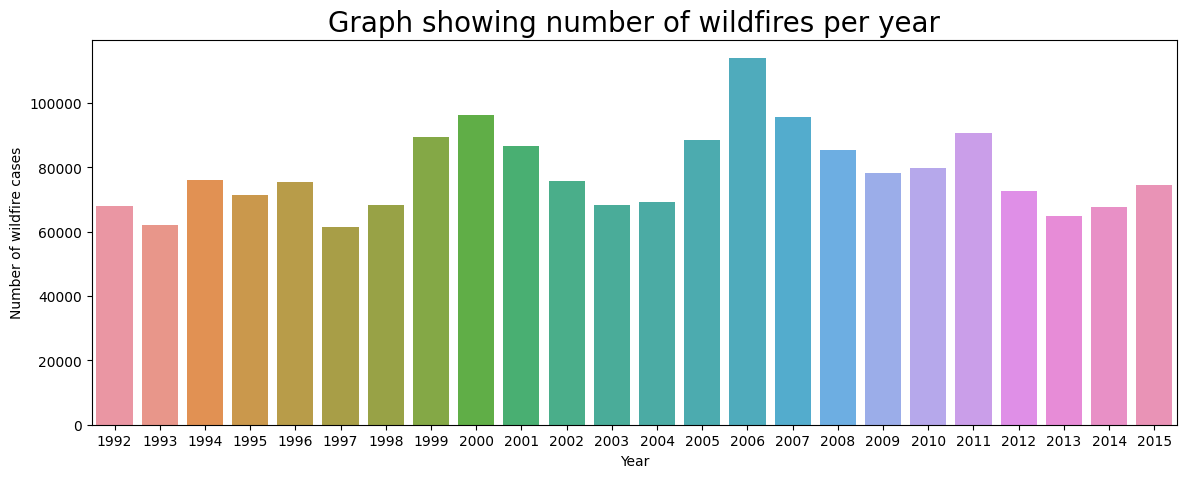

In [15]:
year_data = modified_df.groupby(['FIRE_YEAR']).size().reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(14,5))
g = sns.barplot(data = year_data, y = 'count', x = 'FIRE_YEAR')
plt.xlabel('Year')
plt.ylabel('Number of wildfire cases')
g.axes.set_title('Graph showing number of wildfires per year',fontsize=20)
plt.show()

In [16]:
# A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres
modified_df['FIRE_SIZE_CLASS'].value_counts()

FIRE_SIZE_CLASS
B    939376
A    666919
C    220077
D     28427
E     14107
F      7786
G      3773
Name: count, dtype: int64

In [17]:
fire_size_df = modified_df[['OBJECTID', 'STAT_CAUSE_DESCR']]
fire_size_df.head()

OBJECTID STAT_CAUSE_DESCR
0         1    Miscellaneous
1         2        Lightning
2         3   Debris Burning
3         4        Lightning
4         5        Lightning

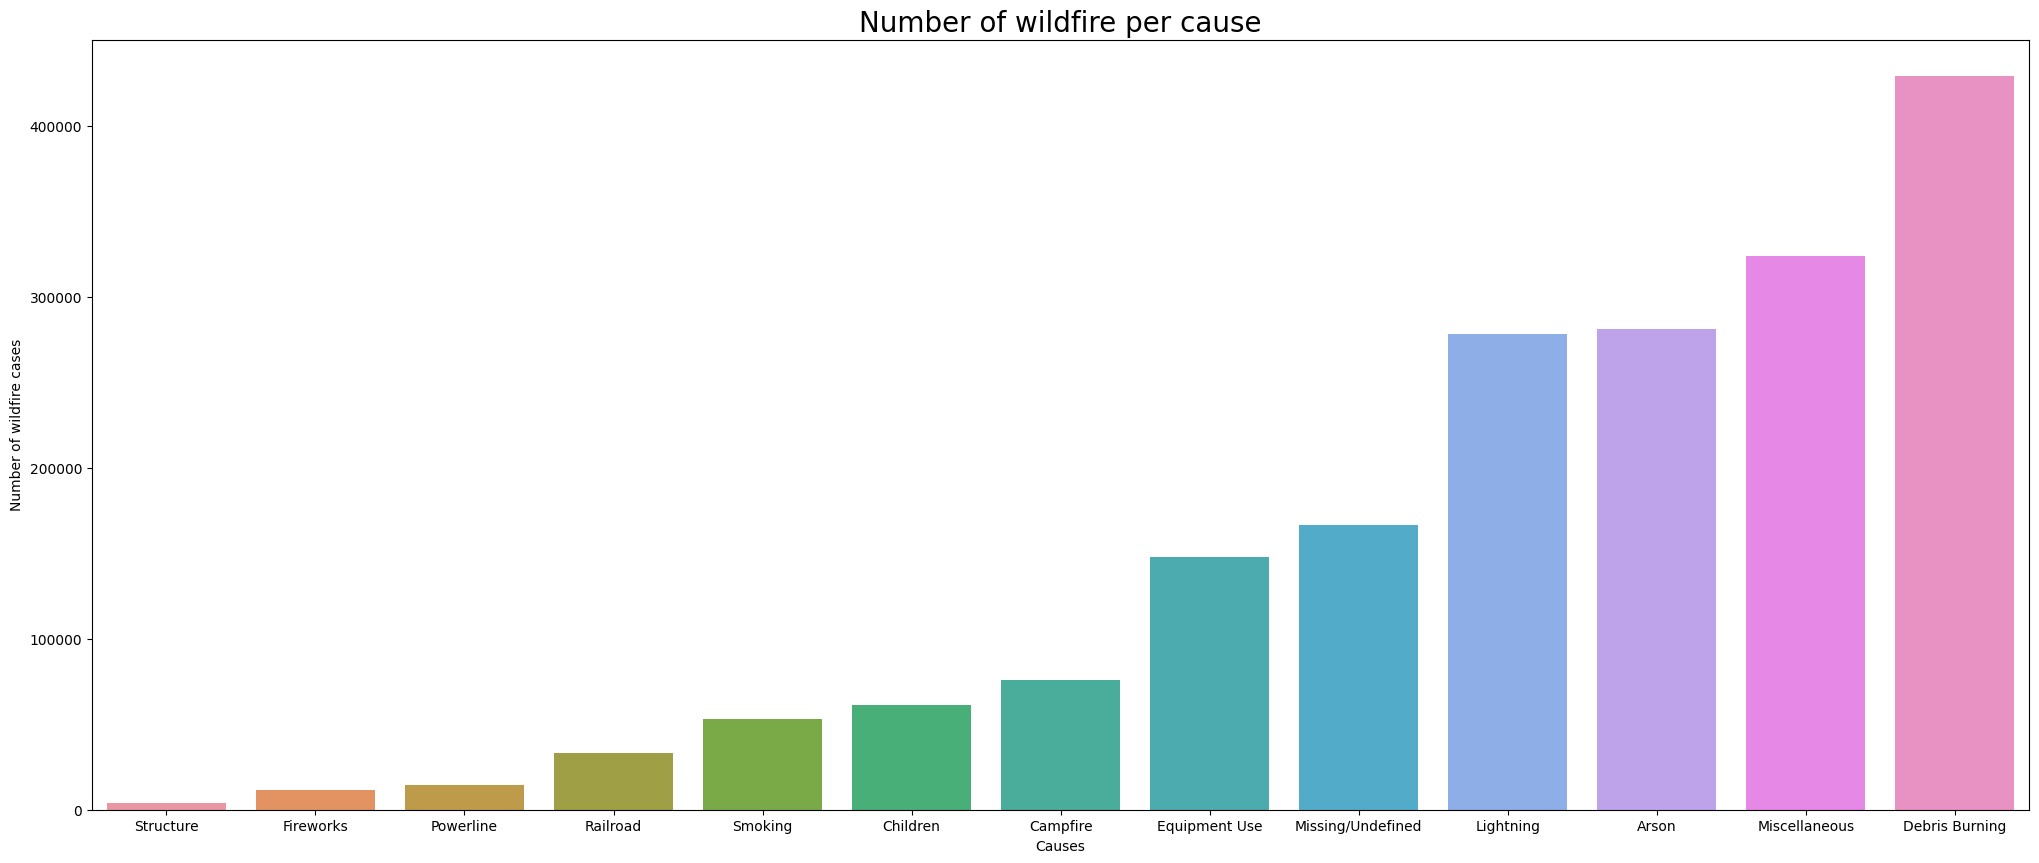

In [18]:
cause_data = fire_size_df.groupby(['STAT_CAUSE_DESCR']).size().reset_index(name = 'count').sort_values('count')

plt.figure(figsize=(25,10))
g = sns.barplot(data = cause_data, y = 'count', x = 'STAT_CAUSE_DESCR')
plt.xlabel('Causes')
plt.ylabel('Number of wildfire cases')
g.axes.set_title('Number of wildfires per cause',fontsize=20)
plt.show()

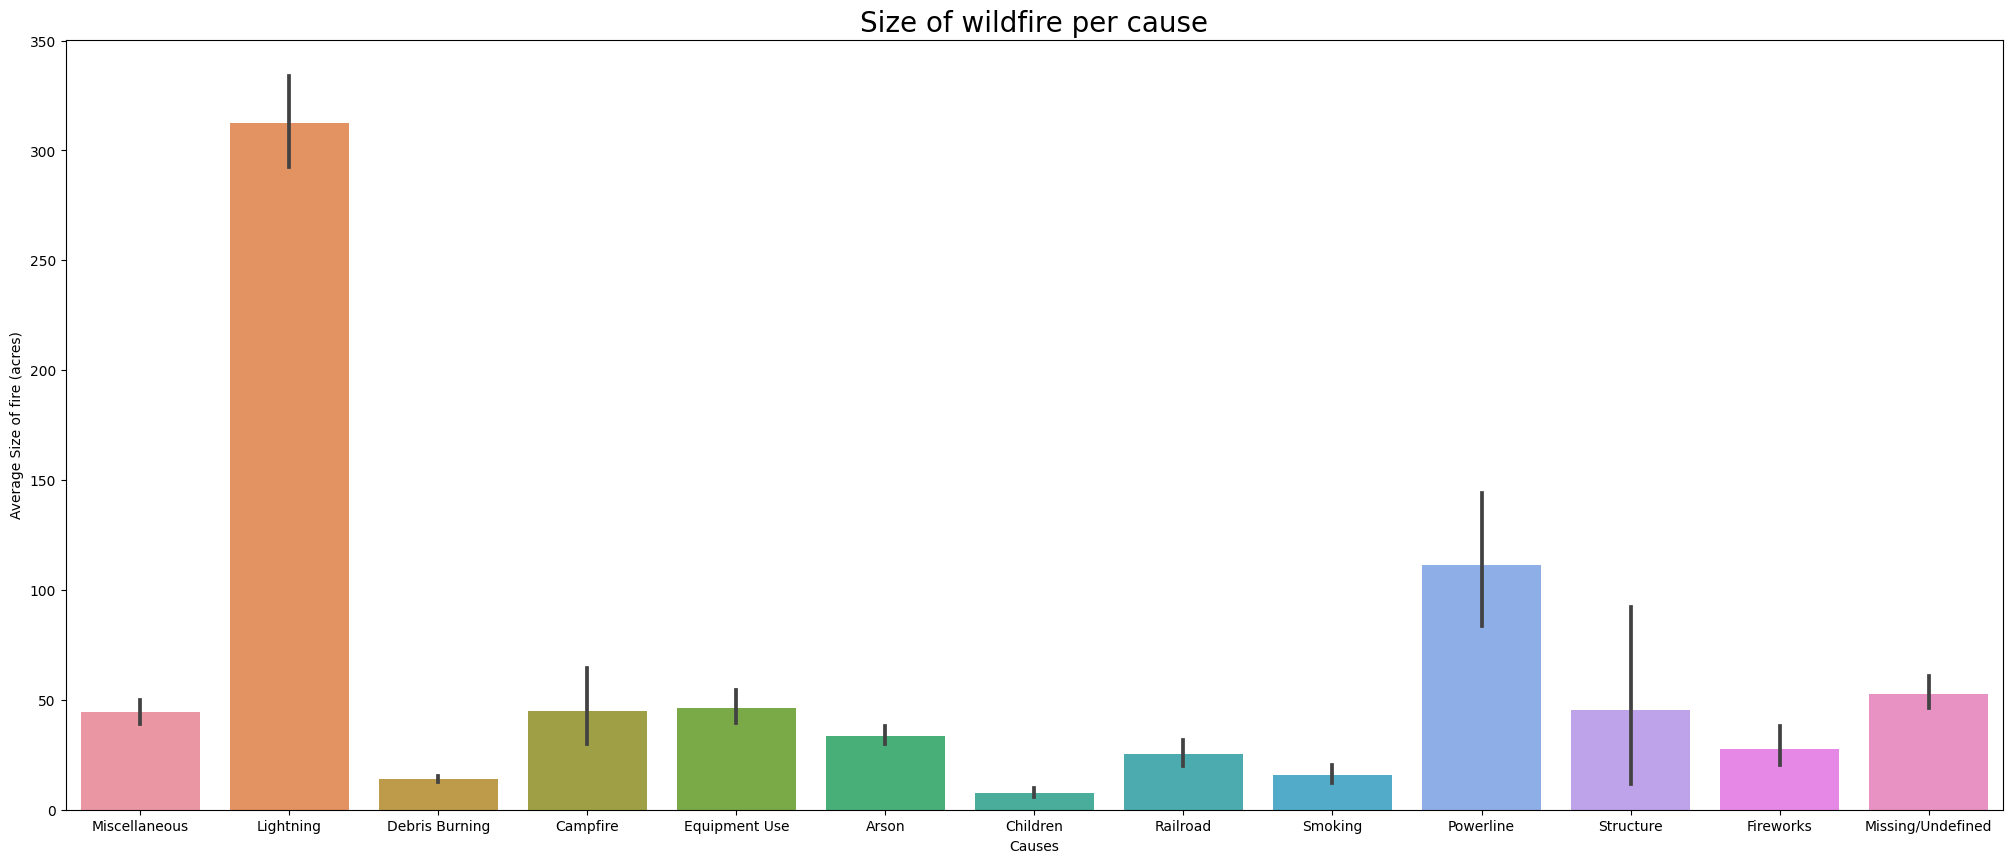

In [19]:
plt.figure(figsize=(25,10))
g = sns.barplot(data = modified_df, y = 'FIRE_SIZE', x = 'STAT_CAUSE_DESCR')
plt.xlabel('Causes')
plt.ylabel('Average Size of fire (acres)')
g.axes.set_title('Size of wildfire per cause',fontsize=20)
plt.show()

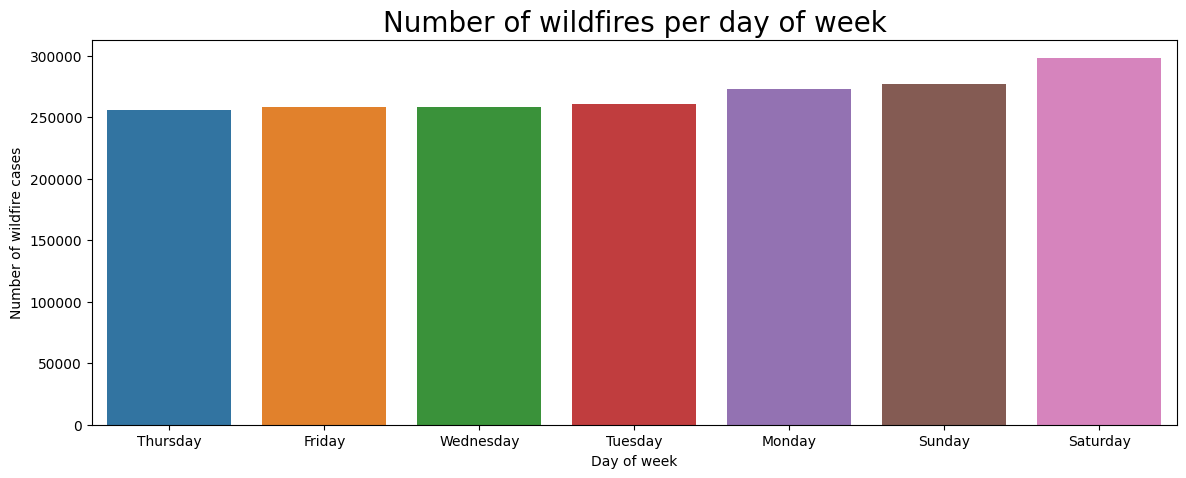

In [20]:
day_of_week = modified_df.groupby(['DAY_OF_WEEK']).size() \
                         .reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(14,5))
g = sns.barplot(data = day_of_week, y = 'count', x = 'DAY_OF_WEEK')
plt.xlabel('Day of week')
plt.ylabel('Number of wildfire cases')
g.axes.set_title('Number of wildfires per day of week',fontsize=20)
plt.show()

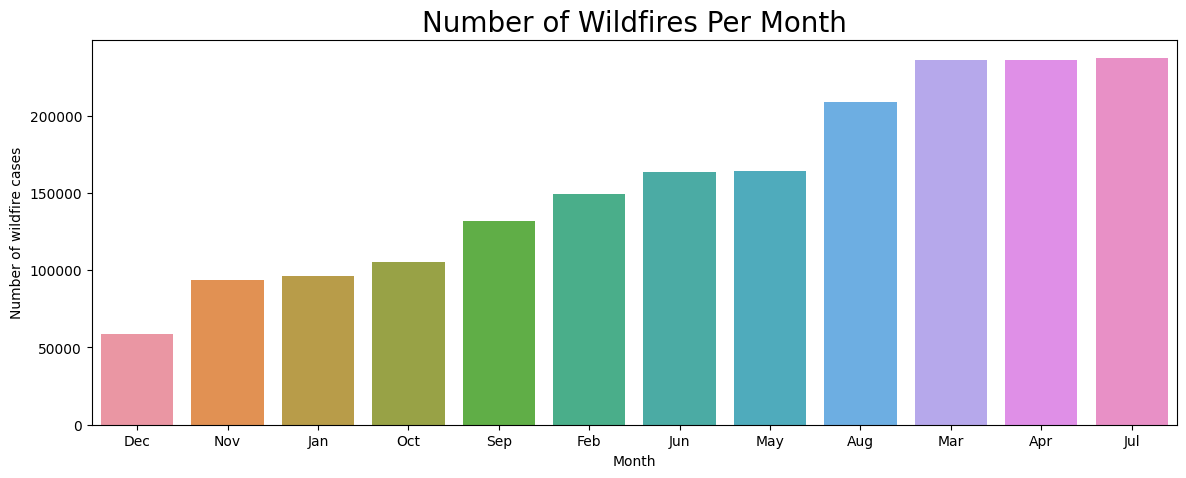

In [21]:
month_data = modified_df.groupby(['MONTH']).size().reset_index(name = 'count') \
                        .sort_values('count')

# Creating barplot
plt.figure(figsize=(14,5))
g = sns.barplot(data = month_data, y = 'count', x = 'MONTH')
plt.xlabel('Month')
plt.ylabel('Number of wildfire cases')
g.axes.set_title('Number of Wildfires Per Month',fontsize=20)
plt.show()

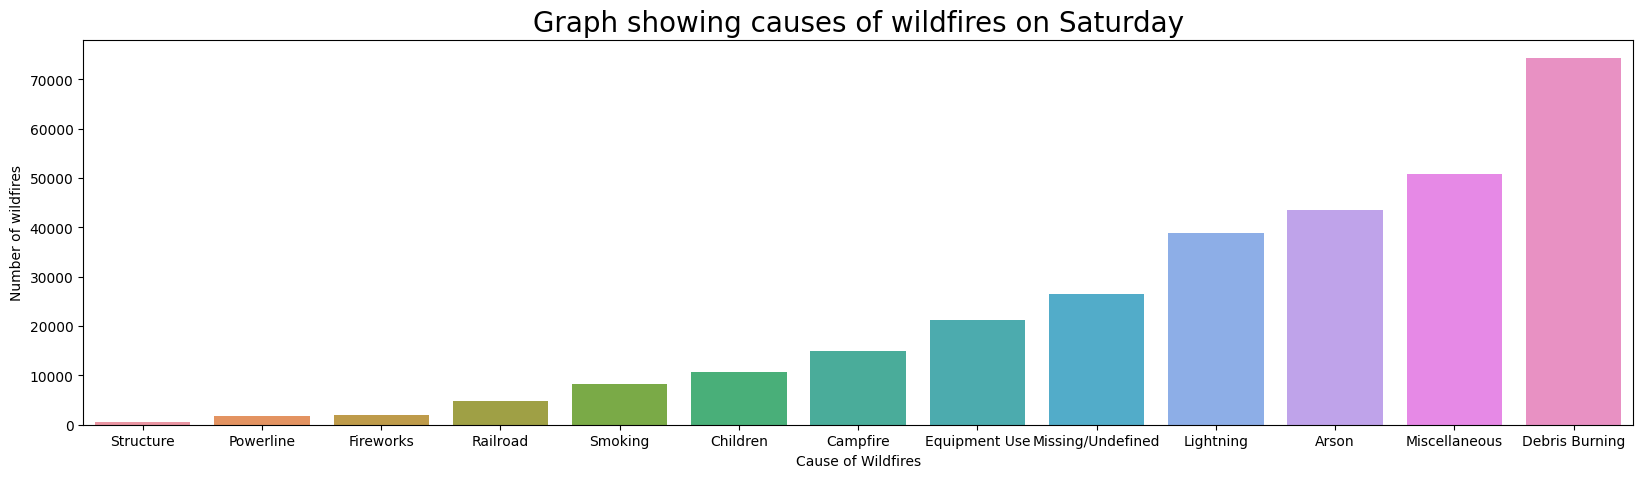

In [23]:
fires_saturday_df = modified_df[modified_df['DAY_OF_WEEK'] == 'Saturday'] \
                    .groupby(['STAT_CAUSE_DESCR']).size() \
                    .reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(20,5))
g = sns.barplot(data = fires_saturday_df, y = 'count', x = 'STAT_CAUSE_DESCR')
plt.xlabel('Cause of Wildfires')
plt.ylabel('Number of wildfires')
g.axes.set_title('Graph showing causes of wildfires on Saturday',fontsize=20)
plt.show()

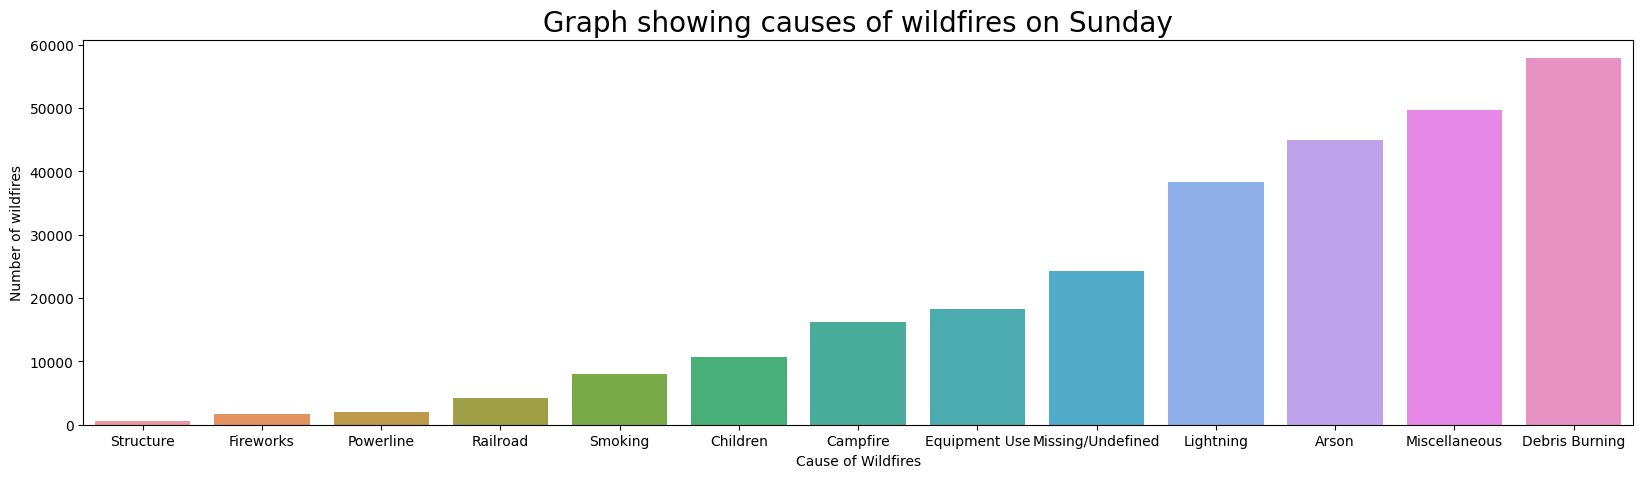

In [41]:
fires_sunday_df = modified_df[modified_df['DAY_OF_WEEK'] == 'Sunday'] \
                    .groupby(['STAT_CAUSE_DESCR']).size() \
                    .reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(20,5))
g = sns.barplot(data = fires_sunday_df, y = 'count', x = 'STAT_CAUSE_DESCR')
plt.xlabel('Cause of Wildfires')
plt.ylabel('Number of wildfires')
g.axes.set_title('Graph showing causes of wildfires on Sunday',fontsize=20)
plt.show()

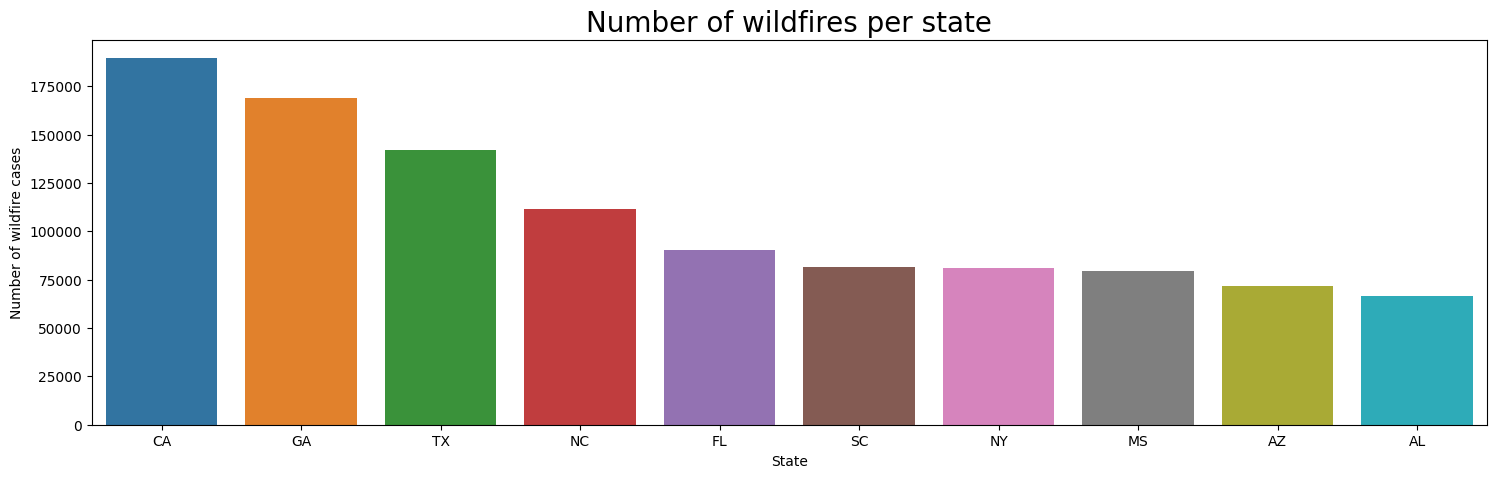

In [25]:
state_data = modified_df.groupby(['STATE']).size().reset_index(name = 'count') \
                        .sort_values('count')

# Creating barplot
plt.figure(figsize=(18,5))
g = sns.barplot(data = state_data.nlargest(10, 'count'), y = 'count', x = 'STATE')
plt.xlabel('State')
plt.ylabel('Number of wildfire cases')
g.axes.set_title('Number of wildfires per state',fontsize=20)
plt.show()

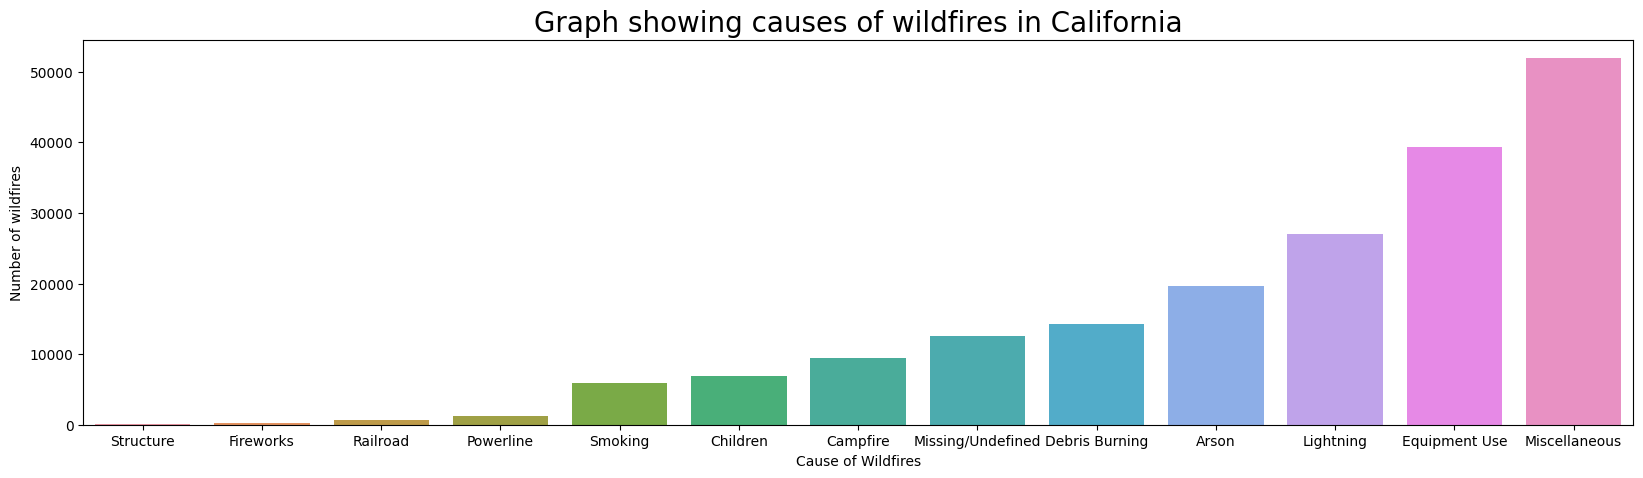

In [26]:
fires_california_df = modified_df[modified_df['STATE'] == 'CA'] \
                    .groupby(['STAT_CAUSE_DESCR']).size() \
                    .reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(20,5))
g = sns.barplot(data = fires_california_df, y = 'count', x = 'STAT_CAUSE_DESCR')
plt.xlabel('Cause of Wildfires')
plt.ylabel('Number of wildfires')
g.axes.set_title('Graph showing causes of wildfires in California',fontsize=20)
plt.show()

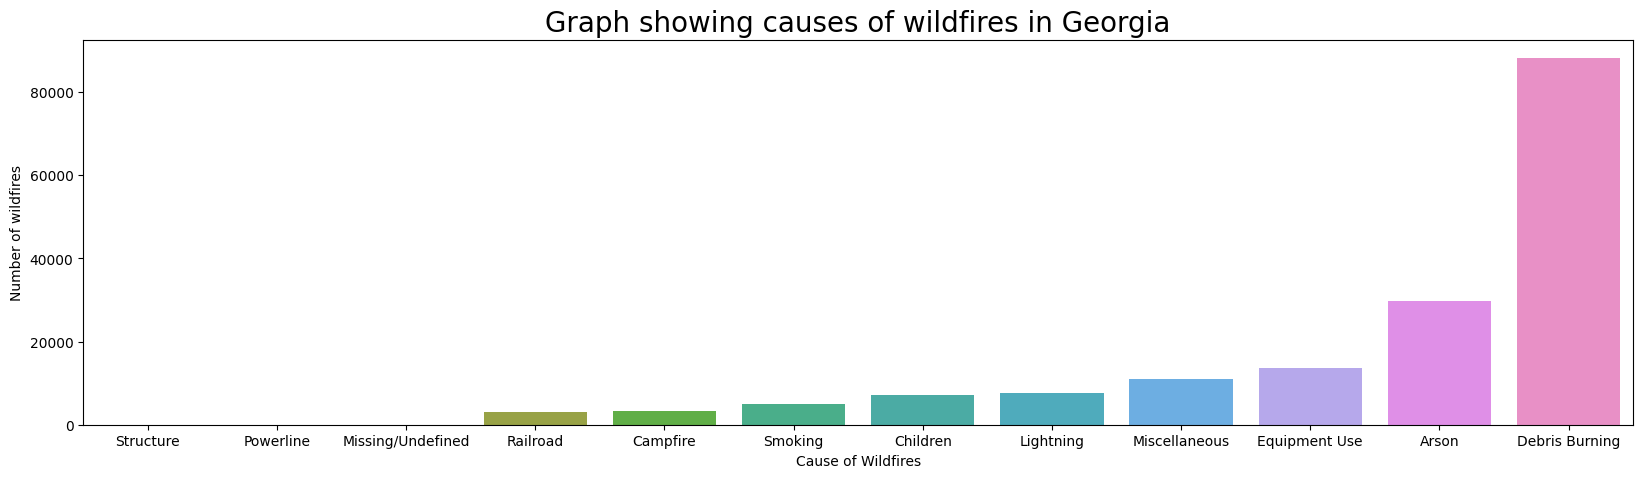

In [27]:
fires_georgia_df = modified_df[modified_df['STATE'] == 'GA'] \
                    .groupby(['STAT_CAUSE_DESCR']).size() \
                    .reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(20,5))
g = sns.barplot(data = fires_georgia_df, y = 'count', x = 'STAT_CAUSE_DESCR')
plt.xlabel('Cause of Wildfires')
plt.ylabel('Number of wildfires')
g.axes.set_title('Graph showing causes of wildfires in Georgia',fontsize=20)
plt.show()

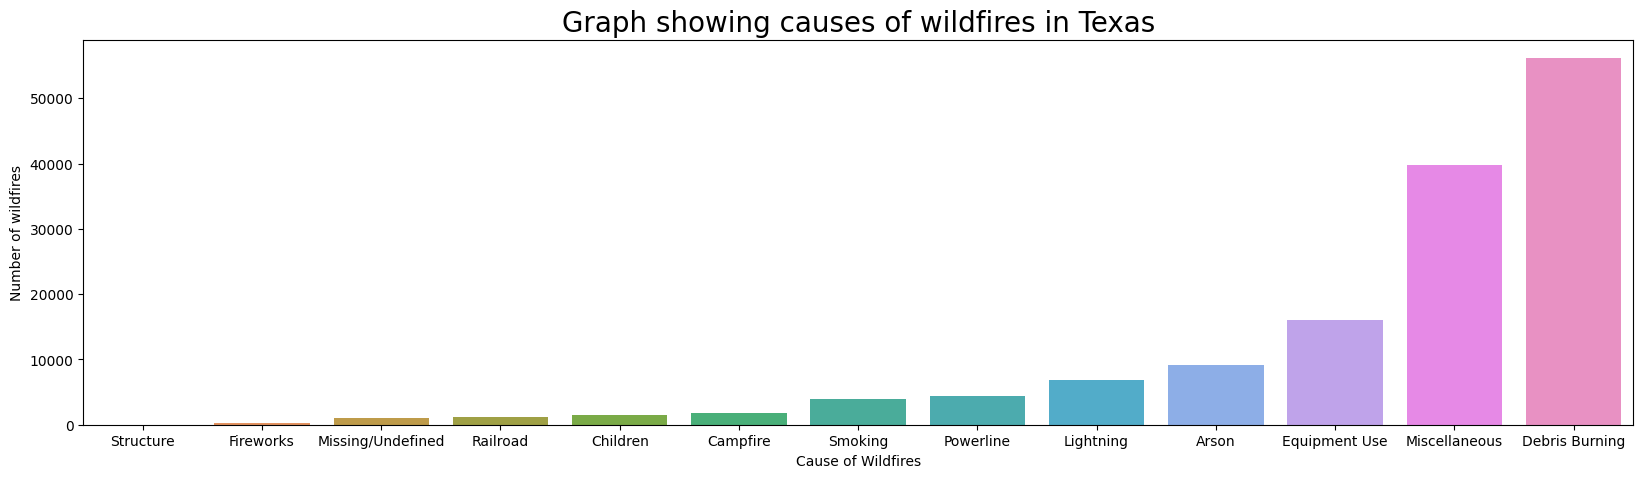

In [28]:
fires_texas_df = modified_df[modified_df['STATE'] == 'TX'] \
                    .groupby(['STAT_CAUSE_DESCR']).size() \
                    .reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(20,5))
g = sns.barplot(data = fires_texas_df, y = 'count', x = 'STAT_CAUSE_DESCR')
plt.xlabel('Cause of Wildfires')
plt.ylabel('Number of wildfires')
g.axes.set_title('Graph showing causes of wildfires in Texas',fontsize=20)
plt.show()

In [29]:
map_df = wildfire_df.loc[(wildfire_df.loc[:,'STATE']!='AK') & (wildfire_df.loc[:,'STATE']!='HI') & (wildfire_df.loc[:,'STATE']!='PR')]

In [30]:
map_df.loc[:,'LATITUDE'] = ((map_df.loc[:,'LATITUDE']*10).apply(np.floor))/10
map_df.loc[:,'LONGITUDE'] = ((map_df.loc[:,'LONGITUDE']*10).apply(np.floor))/10
map_df.loc[:,'LL_COMBO'] = map_df.loc[:,'LATITUDE'].map(str) + '-' + map_df.loc[:,'LONGITUDE'].map(str)

grouped = map_df.groupby(['LL_COMBO', 'LATITUDE', 'LONGITUDE'])

/var/folders/gd/258zt57d36zg52cf6fc28bfh0000gn/T/ipykernel_28685/3602605774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_df.loc[:,'LL_COMBO'] = map_df.loc[:,'LATITUDE'].map(str) + '-' + map_df.loc[:,'LONGITUDE'].map(str)


In [35]:
number_of_wildfires = grouped['FIRE_SIZE'].agg(['count']).reset_index()
number_of_wildfires.head(5)

LL_COMBO  LATITUDE  LONGITUDE  count
0  24.5--81.7      24.5      -81.7      1
1  24.6--81.3      24.6      -81.3      2
2  24.6--81.4      24.6      -81.4    184
3  24.6--81.5      24.6      -81.5     43
4  24.6--81.6      24.6      -81.6     11

In [36]:
size_of_wildfires = grouped['FIRE_SIZE'].agg(['mean']).reset_index()
size_of_wildfires.head(5)

LL_COMBO  LATITUDE  LONGITUDE      mean
0  24.5--81.7      24.5      -81.7  0.500000
1  24.6--81.3      24.6      -81.3  0.100000
2  24.6--81.4      24.6      -81.4  0.501630
3  24.6--81.5      24.6      -81.5  0.646512
4  24.6--81.6      24.6      -81.6  0.954545

In [37]:
source = ColumnDataSource(number_of_wildfires)
p1 = figure(title="Number of wildfires occurring from 1992 to 2015 " + \
            "(lighter color means more wildfires)",
           toolbar_location=None, width=600, height=400)
p1.background_fill_color = "black"
p1.grid.grid_line_color = None
p1.axis.visible = False
color_mapper = LogColorMapper(palette=cc.fire)
glyph = p1.circle('LONGITUDE', 'LATITUDE', source=source,
          color={'field': 'count', 'transform' : color_mapper},
          size=1)
output_notebook()
show(p1)

Loading BokehJS ...

In [40]:
source = ColumnDataSource(size_of_wildfires)
p2 = figure(title="Average size of wildfires occurring from 1992 to 2015 " + \
            "(lighter color means bigger fire)",
           toolbar_location=None, width=600, height=400)
p2.background_fill_color = "black"
p2.grid.grid_line_color = None
p2.axis.visible = False
glyph = p2.circle('LONGITUDE', 'LATITUDE', source=source,
          color={'field': 'mean', 'transform' : color_mapper},
          size=1)
show(p2)